In [1]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras

from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2

from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

/home/tobi-k/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tobi-k/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tobi-k/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tobi-k/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

tf.__version__: 1.14.0
keras.__version__: 2.3.1


image_path: ../image_data/7576_091.png
steering_Angle: 91


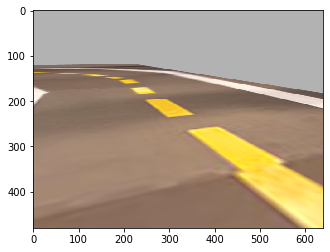

In [2]:
# import images

data_dir = '../image_data'
file_list = os.listdir(data_dir)

image_paths = []
steering_angles = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

image_index = 4444
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([216.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1699.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 6886.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1445.0000]),
 array([-90.0000, -80.6800, -71.3600, -62.0400, -52.7200, -43.4000,
        -34.0800, -24.7600, -15.4400, -6.1200, 3.2000, 12.5200, 21.8400,
        31.1600, 40.4800, 49.8000, 59.1200, 68.4400, 77.7600, 87.0800,
        96.4000, 105.7200, 115.0400, 124.3600, 133.6800, 143.0000]),
 <a list of 25 Patch objects>)

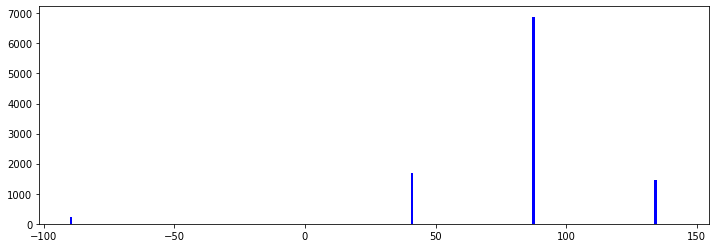

In [3]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 10
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 8196
Validation data: 2050


Text(0.5, 1.0, 'Validation Data')

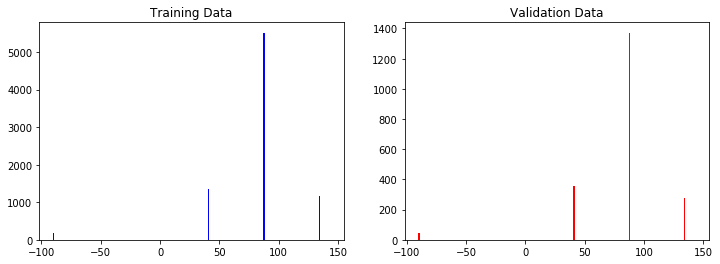

In [4]:
#Split into Train/Test Set

X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'zoomed')

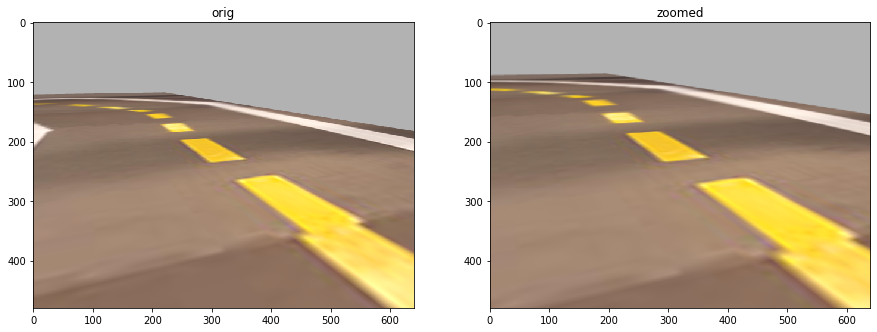

In [5]:
import numpy
numpy.random.bit_generator = numpy.random._bit_generator

def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.5))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

Text(0.5, 1.0, 'panned')

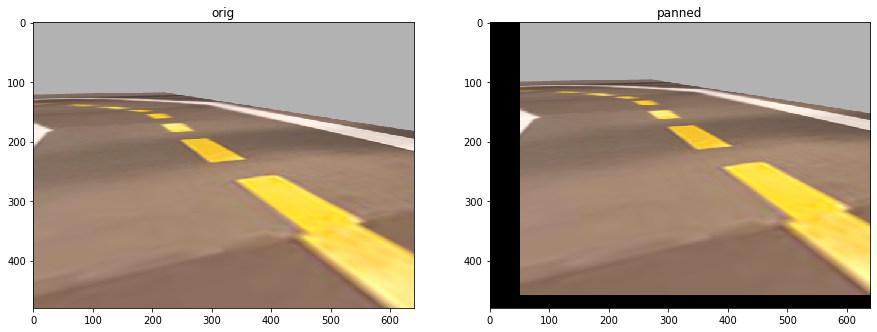

In [6]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

Text(0.5, 1.0, 'brightness adjusted')

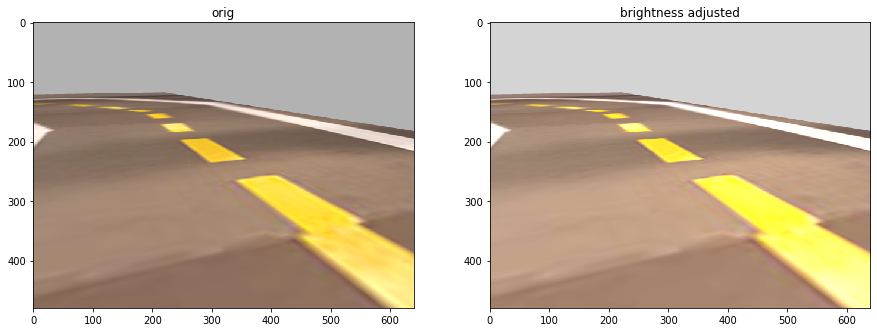

In [7]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

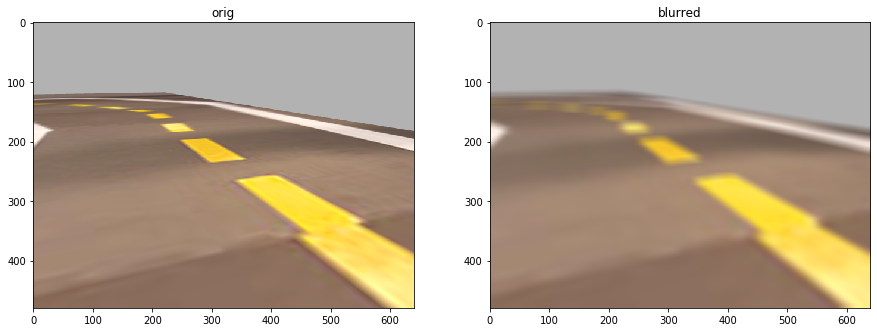

In [8]:
def blur(image):
    kernel_size = random.randint(1, 15)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=89')

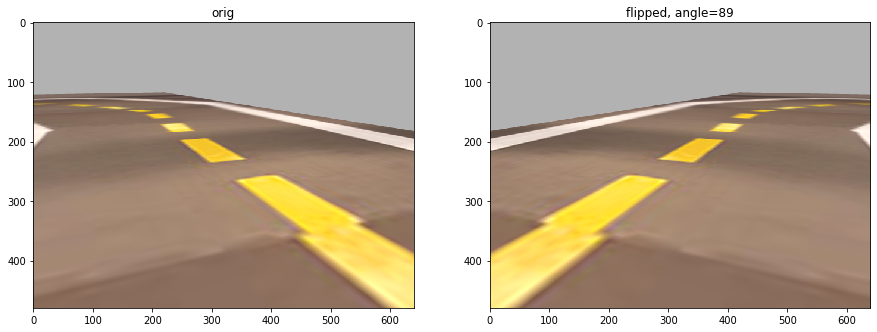

In [9]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

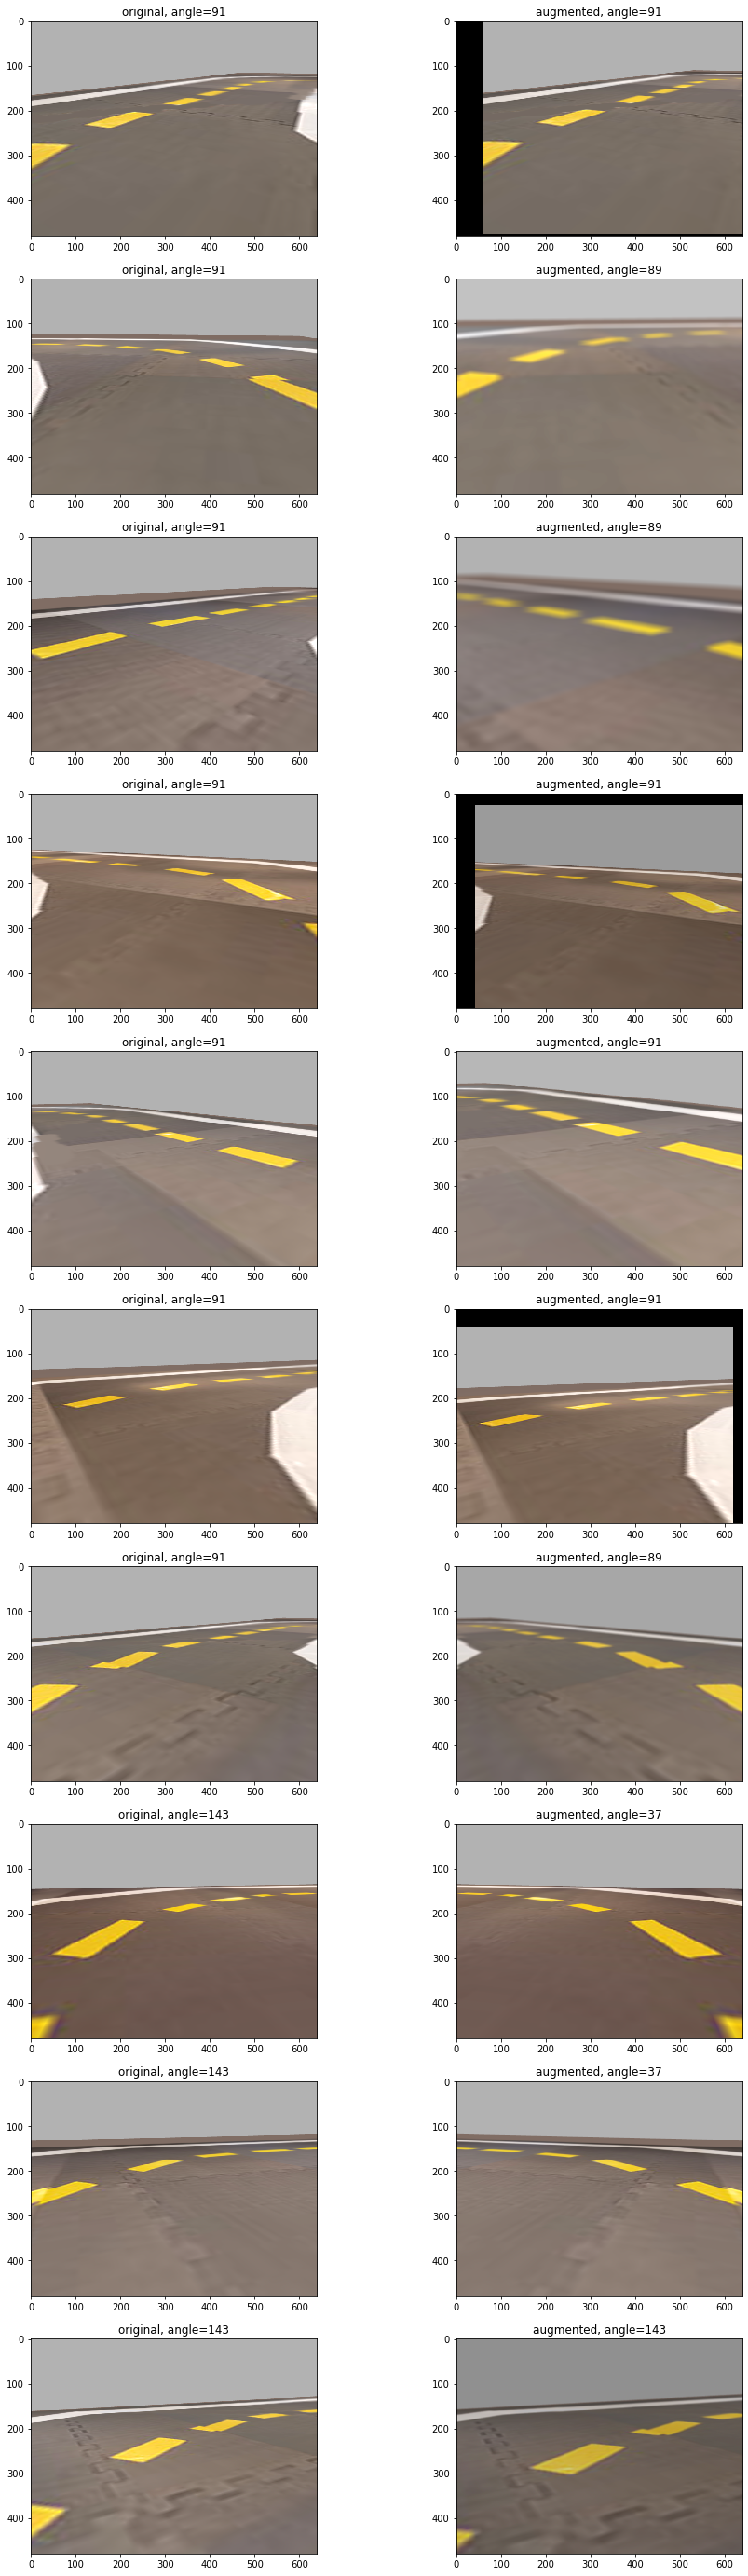

In [10]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)

Text(0.5, 1.0, 'processed')

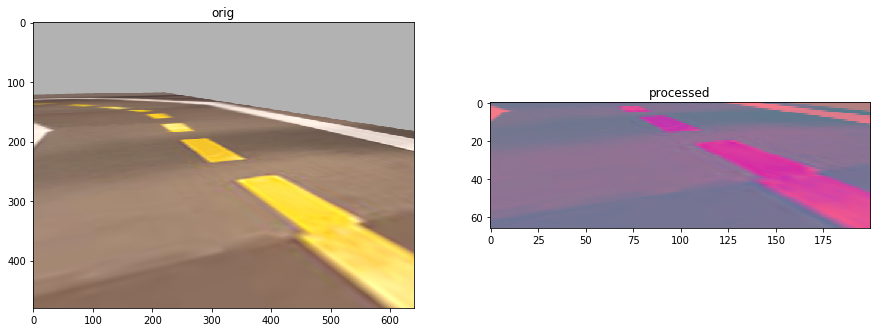

In [12]:
# Preprocess Training Data for Nvidia Model

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/3):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [13]:
from keras.optimizers import Nadam

def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # Adam(lr=1e-3) # lr is learning rate
    # Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [14]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [14]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

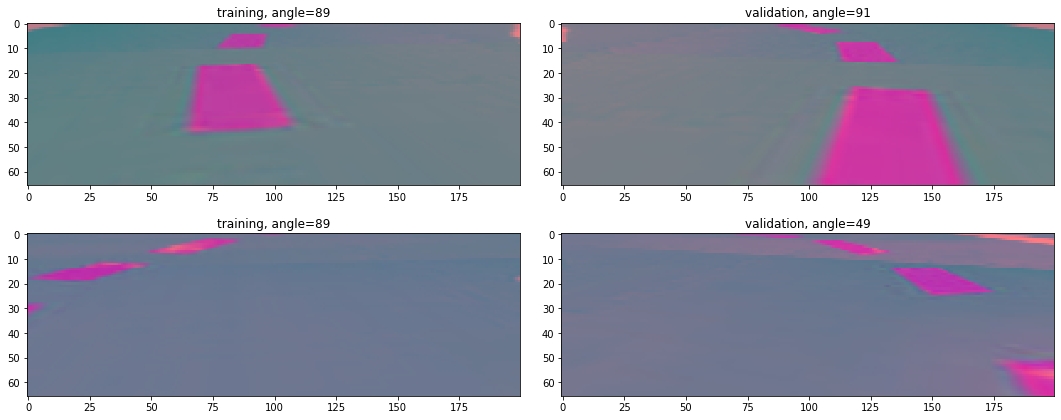

In [15]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [16]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

model_output_dir = '.'

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [17]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

NameError: name 'DO_NOT_RUN_ALL' is not defined

In [18]:
print(len(X_valid))

2050


In [ ]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

num_train_examples = len(X_train)
num_valid_examples = len(X_valid)

batch_size=64

print("lane nav train started")
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=batch_size, is_training=True),
                              steps_per_epoch=num_train_examples//batch_size,
                              epochs=1000,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=batch_size, is_training=False),
                              validation_steps=num_valid_examples//batch_size,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
print("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


lane nav train started

Epoch 1/1000
128/128 [==============================] - 69s 543ms/step - loss: 2692.6784 - val_loss: 1541.1616

Epoch 00001: val_loss improved from inf to 1541.16162, saving model to ./lane_navigation_check.h5
Epoch 2/1000
128/128 [==============================] - 59s 463ms/step - loss: 1351.8383 - val_loss: 1739.2723

Epoch 00002: val_loss did not improve from 1541.16162
Epoch 3/1000
128/128 [==============================] - 60s 465ms/step - loss: 1378.5675 - val_loss: 1833.2078

Epoch 00003: val_loss did not improve from 1541.16162
Epoch 4/1000
128/128 [==============================] - 59s 461ms/step - loss: 1306.4621 - val_loss: 1060.7603

Epoch 00004: val_loss improved from 1541.16162 to 1060.76025, saving model to ./lane_navigation_check.h5
Epoch 5/1000
128/128 [==============================] - 59s 460ms/step - loss: 1333.1963 - val_loss: 1065.4421

Epoch 00005: val_loss did not improve from 1060.76025
Epoch 6/1000
128/128 [=============================

128/128 [==============================] - 59s 461ms/step - loss: 1280.8726 - val_loss: 1113.6130

Epoch 00048: val_loss did not improve from 470.43048
Epoch 49/1000
128/128 [==============================] - 59s 460ms/step - loss: 1325.7187 - val_loss: 2915.3423

Epoch 00049: val_loss did not improve from 470.43048
Epoch 50/1000
128/128 [==============================] - 59s 460ms/step - loss: 1282.2205 - val_loss: 441.8201

Epoch 00050: val_loss improved from 470.43048 to 441.82013, saving model to ./lane_navigation_check.h5
Epoch 51/1000
128/128 [==============================] - 59s 459ms/step - loss: 1270.7062 - val_loss: 834.3115

Epoch 00051: val_loss did not improve from 441.82013
Epoch 52/1000
128/128 [==============================] - 59s 461ms/step - loss: 1307.7001 - val_loss: 954.4435

Epoch 00052: val_loss did not improve from 441.82013
Epoch 53/1000
128/128 [==============================] - 59s 462ms/step - loss: 1275.5603 - val_loss: 1683.7893

Epoch 00053: val_loss di

128/128 [==============================] - 59s 459ms/step - loss: 1088.4452 - val_loss: 769.0245

Epoch 00097: val_loss did not improve from 374.43024
Epoch 98/1000
128/128 [==============================] - 59s 463ms/step - loss: 1103.4967 - val_loss: 1213.1726

Epoch 00098: val_loss did not improve from 374.43024
Epoch 99/1000
128/128 [==============================] - 59s 460ms/step - loss: 1163.8230 - val_loss: 868.3196

Epoch 00099: val_loss did not improve from 374.43024
Epoch 100/1000
128/128 [==============================] - 59s 461ms/step - loss: 1037.2438 - val_loss: 859.5887

Epoch 00100: val_loss did not improve from 374.43024
Epoch 101/1000
128/128 [==============================] - 59s 460ms/step - loss: 1102.2626 - val_loss: 677.2908

Epoch 00101: val_loss did not improve from 374.43024
Epoch 102/1000
128/128 [==============================] - 59s 459ms/step - loss: 1005.3932 - val_loss: 1047.7178

Epoch 00102: val_loss did not improve from 374.43024
Epoch 103/1000
128/

128/128 [==============================] - 59s 459ms/step - loss: 1030.6694 - val_loss: 1225.1165

Epoch 00145: val_loss did not improve from 222.24747
Epoch 146/1000
128/128 [==============================] - 59s 458ms/step - loss: 927.9485 - val_loss: 671.2712

Epoch 00146: val_loss did not improve from 222.24747
Epoch 147/1000
128/128 [==============================] - 59s 460ms/step - loss: 961.1639 - val_loss: 550.5063

Epoch 00147: val_loss did not improve from 222.24747
Epoch 148/1000
128/128 [==============================] - 59s 459ms/step - loss: 973.3821 - val_loss: 811.0696

Epoch 00148: val_loss did not improve from 222.24747
Epoch 149/1000
128/128 [==============================] - 59s 460ms/step - loss: 935.5991 - val_loss: 514.8001

Epoch 00149: val_loss did not improve from 222.24747
Epoch 150/1000
128/128 [==============================] - 59s 460ms/step - loss: 853.7682 - val_loss: 735.4164

Epoch 00150: val_loss did not improve from 222.24747
Epoch 151/1000
128/128 

128/128 [==============================] - 59s 459ms/step - loss: 780.5405 - val_loss: 816.8384

Epoch 00243: val_loss did not improve from 164.86615
Epoch 244/1000
128/128 [==============================] - 59s 459ms/step - loss: 805.5425 - val_loss: 303.0353

Epoch 00244: val_loss did not improve from 164.86615
Epoch 245/1000
128/128 [==============================] - 59s 460ms/step - loss: 767.7802 - val_loss: 159.9769

Epoch 00245: val_loss improved from 164.86615 to 159.97687, saving model to ./lane_navigation_check.h5
Epoch 246/1000
128/128 [==============================] - 59s 462ms/step - loss: 823.3498 - val_loss: 227.5435

Epoch 00246: val_loss did not improve from 159.97687
Epoch 247/1000
128/128 [==============================] - 59s 461ms/step - loss: 778.3336 - val_loss: 794.8531

Epoch 00247: val_loss did not improve from 159.97687
Epoch 248/1000
128/128 [==============================] - 59s 460ms/step - loss: 823.4305 - val_loss: 560.2209

Epoch 00248: val_loss did no

128/128 [==============================] - 59s 460ms/step - loss: 687.7043 - val_loss: 703.3403

Epoch 00341: val_loss did not improve from 108.28944
Epoch 342/1000
128/128 [==============================] - 59s 460ms/step - loss: 697.7555 - val_loss: 604.0004

Epoch 00342: val_loss did not improve from 108.28944
Epoch 343/1000
128/128 [==============================] - 59s 459ms/step - loss: 671.5702 - val_loss: 285.3128

Epoch 00343: val_loss did not improve from 108.28944
Epoch 344/1000
128/128 [==============================] - 59s 459ms/step - loss: 716.5173 - val_loss: 694.5258

Epoch 00344: val_loss did not improve from 108.28944
Epoch 345/1000
128/128 [==============================] - 59s 460ms/step - loss: 788.2844 - val_loss: 288.7159

Epoch 00345: val_loss did not improve from 108.28944
Epoch 346/1000
128/128 [==============================] - 59s 458ms/step - loss: 652.5000 - val_loss: 215.0961

Epoch 00346: val_loss did not improve from 108.28944
Epoch 347/1000
128/128 [=

128/128 [==============================] - 59s 458ms/step - loss: 688.2510 - val_loss: 892.2340

Epoch 00391: val_loss did not improve from 108.28944
Epoch 392/1000
128/128 [==============================] - 59s 459ms/step - loss: 737.4693 - val_loss: 213.4716

Epoch 00392: val_loss did not improve from 108.28944
Epoch 393/1000
128/128 [==============================] - 59s 461ms/step - loss: 687.8001 - val_loss: 1652.7306

Epoch 00393: val_loss did not improve from 108.28944
Epoch 394/1000
128/128 [==============================] - 59s 460ms/step - loss: 735.4458 - val_loss: 628.3283

Epoch 00394: val_loss did not improve from 108.28944
Epoch 395/1000
128/128 [==============================] - 59s 460ms/step - loss: 693.6372 - val_loss: 297.6704

Epoch 00395: val_loss did not improve from 108.28944
Epoch 396/1000
128/128 [==============================] - 59s 461ms/step - loss: 689.1523 - val_loss: 254.5885

Epoch 00396: val_loss did not improve from 108.28944
Epoch 397/1000
128/128 [


Epoch 00440: val_loss did not improve from 90.15940
Epoch 441/1000
128/128 [==============================] - 59s 460ms/step - loss: 698.2319 - val_loss: 991.4855

Epoch 00441: val_loss did not improve from 90.15940
Epoch 442/1000
128/128 [==============================] - 59s 460ms/step - loss: 707.4107 - val_loss: 338.2105

Epoch 00442: val_loss did not improve from 90.15940
Epoch 443/1000
128/128 [==============================] - 59s 458ms/step - loss: 676.8567 - val_loss: 174.9649

Epoch 00443: val_loss did not improve from 90.15940
Epoch 444/1000
128/128 [==============================] - 59s 461ms/step - loss: 705.0117 - val_loss: 213.7612

Epoch 00444: val_loss did not improve from 90.15940
Epoch 445/1000
128/128 [==============================] - 59s 461ms/step - loss: 632.7794 - val_loss: 156.7842

Epoch 00445: val_loss did not improve from 90.15940
Epoch 446/1000
128/128 [==============================] - 59s 461ms/step - loss: 662.3516 - val_loss: 508.1628

Epoch 00446: va


Epoch 00490: val_loss did not improve from 90.15940
Epoch 491/1000
128/128 [==============================] - 59s 459ms/step - loss: 695.1756 - val_loss: 1449.5552

Epoch 00491: val_loss did not improve from 90.15940
Epoch 492/1000
128/128 [==============================] - 59s 461ms/step - loss: 637.5039 - val_loss: 140.2496

Epoch 00492: val_loss did not improve from 90.15940
Epoch 493/1000
128/128 [==============================] - 59s 463ms/step - loss: 667.3429 - val_loss: 927.6301

Epoch 00493: val_loss did not improve from 90.15940
Epoch 494/1000
128/128 [==============================] - 59s 458ms/step - loss: 765.0603 - val_loss: 269.8220

Epoch 00494: val_loss did not improve from 90.15940
Epoch 495/1000
128/128 [==============================] - 59s 459ms/step - loss: 679.9591 - val_loss: 190.6318

Epoch 00495: val_loss did not improve from 90.15940
Epoch 496/1000
128/128 [==============================] - 59s 459ms/step - loss: 621.5547 - val_loss: 228.0044

Epoch 00496: v


Epoch 00540: val_loss did not improve from 90.15940
Epoch 541/1000
128/128 [==============================] - 59s 460ms/step - loss: 611.9128 - val_loss: 338.5031

Epoch 00541: val_loss did not improve from 90.15940
Epoch 542/1000
128/128 [==============================] - 59s 460ms/step - loss: 655.8295 - val_loss: 238.2666

Epoch 00542: val_loss did not improve from 90.15940
Epoch 543/1000
128/128 [==============================] - 59s 459ms/step - loss: 627.7014 - val_loss: 314.9214

Epoch 00543: val_loss did not improve from 90.15940
Epoch 544/1000
128/128 [==============================] - 59s 458ms/step - loss: 611.2140 - val_loss: 240.6369

Epoch 00544: val_loss did not improve from 90.15940
Epoch 545/1000
128/128 [==============================] - 59s 459ms/step - loss: 699.4634 - val_loss: 215.8867

Epoch 00545: val_loss did not improve from 90.15940
Epoch 546/1000
128/128 [==============================] - 59s 460ms/step - loss: 560.8831 - val_loss: 245.8491

Epoch 00546: va


Epoch 00590: val_loss did not improve from 90.15940
Epoch 591/1000
128/128 [==============================] - 59s 461ms/step - loss: 623.6933 - val_loss: 931.5789

Epoch 00591: val_loss did not improve from 90.15940
Epoch 592/1000
128/128 [==============================] - 59s 461ms/step - loss: 671.8036 - val_loss: 237.5946

Epoch 00592: val_loss did not improve from 90.15940
Epoch 593/1000
128/128 [==============================] - 59s 459ms/step - loss: 622.6731 - val_loss: 1078.8020

Epoch 00593: val_loss did not improve from 90.15940
Epoch 594/1000
128/128 [==============================] - 59s 459ms/step - loss: 583.9636 - val_loss: 899.4074

Epoch 00594: val_loss did not improve from 90.15940
Epoch 595/1000
128/128 [==============================] - 59s 460ms/step - loss: 598.2438 - val_loss: 849.5042

Epoch 00595: val_loss did not improve from 90.15940
Epoch 596/1000
128/128 [==============================] - 59s 460ms/step - loss: 651.2397 - val_loss: 150.6625

Epoch 00596: v


Epoch 00640: val_loss did not improve from 90.15940
Epoch 641/1000
128/128 [==============================] - 100s 782ms/step - loss: 663.4465 - val_loss: 294.2386

Epoch 00641: val_loss did not improve from 90.15940
Epoch 642/1000
128/128 [==============================] - 100s 782ms/step - loss: 634.1298 - val_loss: 263.9518

Epoch 00642: val_loss did not improve from 90.15940
Epoch 643/1000
128/128 [==============================] - 100s 782ms/step - loss: 635.8759 - val_loss: 196.8719

Epoch 00643: val_loss did not improve from 90.15940
Epoch 644/1000
128/128 [==============================] - 71s 557ms/step - loss: 585.9622 - val_loss: 958.4709

Epoch 00644: val_loss did not improve from 90.15940
Epoch 645/1000
128/128 [==============================] - 101s 786ms/step - loss: 691.0026 - val_loss: 588.7278

Epoch 00645: val_loss did not improve from 90.15940
Epoch 646/1000
128/128 [==============================] - 101s 788ms/step - loss: 573.0438 - val_loss: 222.0894

Epoch 0064


Epoch 00690: val_loss did not improve from 90.15940
Epoch 691/1000
128/128 [==============================] - 59s 463ms/step - loss: 623.3279 - val_loss: 567.4493

Epoch 00691: val_loss did not improve from 90.15940
Epoch 692/1000
128/128 [==============================] - 59s 460ms/step - loss: 644.5825 - val_loss: 381.8454

Epoch 00692: val_loss did not improve from 90.15940
Epoch 693/1000
128/128 [==============================] - 59s 460ms/step - loss: 590.1710 - val_loss: 483.7366

Epoch 00693: val_loss did not improve from 90.15940
Epoch 694/1000
128/128 [==============================] - 59s 460ms/step - loss: 635.7889 - val_loss: 229.2700

Epoch 00694: val_loss did not improve from 90.15940
Epoch 695/1000
128/128 [==============================] - 59s 461ms/step - loss: 632.0061 - val_loss: 637.1673

Epoch 00695: val_loss did not improve from 90.15940
Epoch 696/1000
128/128 [==============================] - 59s 462ms/step - loss: 620.8623 - val_loss: 470.3486

Epoch 00696: va


Epoch 00740: val_loss did not improve from 90.15940
Epoch 741/1000
128/128 [==============================] - 59s 460ms/step - loss: 607.7974 - val_loss: 176.7130

Epoch 00741: val_loss did not improve from 90.15940
Epoch 742/1000
128/128 [==============================] - 59s 461ms/step - loss: 665.2749 - val_loss: 897.2640

Epoch 00742: val_loss did not improve from 90.15940
Epoch 743/1000
128/128 [==============================] - 59s 459ms/step - loss: 617.9278 - val_loss: 310.8423

Epoch 00743: val_loss did not improve from 90.15940
Epoch 744/1000
128/128 [==============================] - 59s 460ms/step - loss: 582.9883 - val_loss: 199.3031

Epoch 00744: val_loss did not improve from 90.15940
Epoch 745/1000
128/128 [==============================] - 59s 461ms/step - loss: 636.0688 - val_loss: 198.8485

Epoch 00745: val_loss did not improve from 90.15940
Epoch 746/1000
128/128 [==============================] - 59s 460ms/step - loss: 561.0903 - val_loss: 165.5612

Epoch 00746: va


Epoch 00790: val_loss did not improve from 90.15940
Epoch 791/1000
128/128 [==============================] - 59s 460ms/step - loss: 617.3270 - val_loss: 168.8173

Epoch 00791: val_loss did not improve from 90.15940
Epoch 792/1000
128/128 [==============================] - 59s 459ms/step - loss: 576.0920 - val_loss: 220.3739

Epoch 00792: val_loss did not improve from 90.15940
Epoch 793/1000
128/128 [==============================] - 59s 462ms/step - loss: 592.4829 - val_loss: 830.2186

Epoch 00793: val_loss did not improve from 90.15940
Epoch 794/1000
128/128 [==============================] - 59s 458ms/step - loss: 545.4654 - val_loss: 120.6726

Epoch 00794: val_loss did not improve from 90.15940
Epoch 795/1000
128/128 [==============================] - 59s 461ms/step - loss: 618.8869 - val_loss: 367.0255

Epoch 00795: val_loss did not improve from 90.15940
Epoch 796/1000
128/128 [==============================] - 59s 460ms/step - loss: 625.1755 - val_loss: 288.5517

Epoch 00796: va

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


128/128 [==============================] - 5825s 46s/step - loss: 582.7643 - val_loss: 779.2009

Epoch 00849: val_loss did not improve from 80.93538
Epoch 850/1000
128/128 [==============================] - 97s 758ms/step - loss: 574.8762 - val_loss: 285.8663

Epoch 00850: val_loss did not improve from 80.93538
Epoch 851/1000
128/128 [==============================] - 108s 846ms/step - loss: 709.1413 - val_loss: 117.8534

Epoch 00851: val_loss did not improve from 80.93538
Epoch 852/1000
128/128 [==============================] - 109s 848ms/step - loss: 605.7884 - val_loss: 113.3841

Epoch 00852: val_loss did not improve from 80.93538
Epoch 853/1000
128/128 [==============================] - 109s 849ms/step - loss: 593.8307 - val_loss: 794.6906

Epoch 00853: val_loss did not improve from 80.93538
Epoch 854/1000
128/128 [==============================] - 109s 849ms/step - loss: 592.6211 - val_loss: 599.7608

Epoch 00854: val_loss did not improve from 80.93538
Epoch 855/1000
128/128 [===


Epoch 00898: val_loss did not improve from 78.53453
Epoch 899/1000
128/128 [==============================] - 103s 808ms/step - loss: 551.5649 - val_loss: 188.7149

Epoch 00899: val_loss did not improve from 78.53453
Epoch 900/1000
128/128 [==============================] - 106s 826ms/step - loss: 635.2473 - val_loss: 1429.9641

Epoch 00900: val_loss did not improve from 78.53453
Epoch 901/1000
128/128 [==============================] - 106s 827ms/step - loss: 631.8971 - val_loss: 703.1693

Epoch 00901: val_loss did not improve from 78.53453
Epoch 902/1000
128/128 [==============================] - 104s 813ms/step - loss: 600.7338 - val_loss: 312.2986

Epoch 00902: val_loss did not improve from 78.53453
Epoch 903/1000
128/128 [==============================] - 104s 815ms/step - loss: 544.8662 - val_loss: 136.3519

Epoch 00903: val_loss did not improve from 78.53453
Epoch 904/1000
128/128 [==============================] - 105s 820ms/step - loss: 564.4658 - val_loss: 449.3334

Epoch 00

In [17]:
history.history

NameError: name 'history' is not defined

In [18]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)


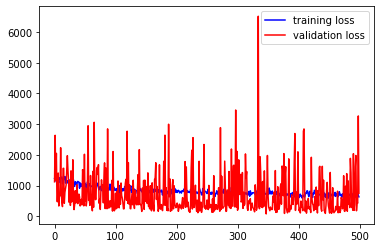

In [19]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred


mse       = 2.2e+02
r_squared = 87.17%



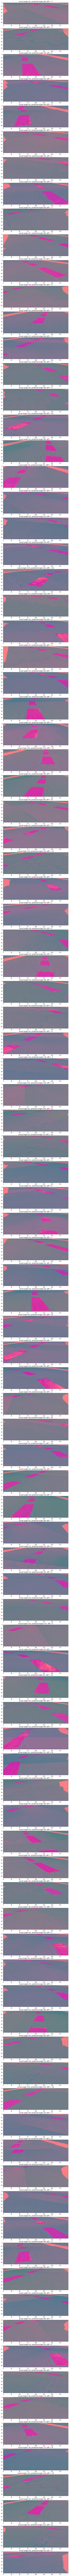

In [21]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 100
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")